(hs_invertibility_example)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

```{index} single: python
```

# Shock Non Invertibility

```{contents} Contents
:depth: 2
```

## Overview

This is another member of a suite of lectures that use the quantecon DLE class to instantiate models within the
{cite}`HS2013` class of models described  in {doc}`Recursive Models of Dynamic Linear Economies <hs_recursive_models>`.

In addition to what's in Anaconda, this lecture uses the quantecon library.

In [1]:
!pip install --upgrade quantecon

We'll make these imports:

In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from quantecon import LQ
from quantecon import DLE
from math import sqrt
%matplotlib inline

This lecture describes  an early contribution to what is now often called
a **news and noise** issue.

In particular, it analyzes  a **shock-invertibility** issue that is
endemic within a class of permanent income models.

Technically, the invertibility problem indicates a situation in which
histories of the shocks in an econometrician's autoregressive or Wold
moving average representation span a smaller information space than do
the shocks that are seen by the agents inside the econometrician's model.

An econometrician who is unaware of the
problem would  misinterpret  shocks and likely responses to them.

A shock-invertibility that is technically close to the one studied here is discussed by
Eric Leeper, Todd Walker, and Susan Yang {cite}`Leeper_Walker_Yang` in their  analysis of **fiscal foresight**.

A distinct shock-invertibility issue is present in the special LQ consumption smoothing model
in this quantecon lecture {doc}`cons_news`.

## Model

We consider the following modification  of Robert Hall's (1978) model {cite}`Hall1978` in which the endowment process is the sum of two orthogonal autoregressive processes:

**Preferences**

$$
-\frac{1}{2}\mathbb{E}\sum_{t=0}^\infty \beta^t[(c_t - b_t)^2 + l_t^2]|J_0
$$

$$
s_t = c_t
$$

$$
b_t = U_bz_t
$$

**Technology**

$$
c_t + i_t = \gamma k_{t-1} + d_t
$$

$$
k_t = \delta_k k_{t-1} + i_t
$$

$$
g_t = \phi_1 i_t \, , \phi_1 > 0
$$

$$
g_t \cdot g_t = l_t^2
$$

**Information**

$$
z_{t+1} =
\left[ {\begin{array}{cccccc}
   1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0.9 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0
   \end{array} }
   \right]
   z_t +
    \left[ {\begin{array}{cc}
   0 & 0 \\ 1 & 0 \\ 0 & 4 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0
   \end{array} }
   \right]
   w_{t+1}
$$

$$
U_b =
  \left[ {\begin{array}{cccccc}
  30 & 0 & 0 & 0 & 0 & 0
  \end{array} }
  \right]
$$

$$
U_d =
   \left[ {\begin{array}{cccccc}
   5 & 1 & 1 & 0.8 & 0.6 & 0.4 \\ 0 & 0 & 0 & 0 & 0 & 0
   \end{array} }
   \right]
$$

The preference shock is constant at 30, while the endowment process is
the sum of a constant and two orthogonal processes.

Specifically:

$$
d_t = 5 + d_{1t} + d_{2t}
$$

$$
d_{1t} = 0.9d_{1t-1} + w_{1t}
$$

$$
d_{2t} = 4w_{2t} + 0.8(4w_{2t-1})+ 0.6(4w_{2t-2})+ 0.4(4w_{2t-3})
$$

$d_{1t}$ is a first-order AR process, while $d_{2t}$ is a
third-order pure moving average process.

In [3]:
γ_1 = 0.05
γ = np.array([[γ_1], [0]])
ϕ_c = np.array([[1], [0]])
ϕ_g = np.array([[0], [1]])
ϕ_1 = 0.00001
ϕ_i = np.array([[1], [-ϕ_1]])
δ_k = np.array([[1]])
θ_k = np.array([[1]])
β = np.array([[1 / 1.05]])
l_λ = np.array([[0]])
π_h = np.array([[1]])
δ_h = np.array([[.9]])
θ_h = np.array([[1]]) - δ_h
ud = np.array([[5, 1, 1, 0.8, 0.6, 0.4],
               [0, 0, 0,   0,   0,   0]])
a22 = np.zeros((6, 6))
# Chase's great trick
a22[[0, 1, 3, 4, 5], [0, 1, 2, 3, 4]] = np.array([1.0, 0.9, 1.0, 1.0, 1.0])
c2 = np.zeros((6, 2))
c2[[1, 2], [0, 1]] = np.array([1.0, 4.0])
ub = np.array([[30, 0, 0, 0, 0, 0]])
x0 = np.array([[5], [150], [1], [0], [0], [0], [0], [0]])

info1 = (a22, c2, ub, ud)
tech1 = (ϕ_c, ϕ_g, ϕ_i, γ, δ_k, θ_k)
pref1 = (β, l_λ, π_h, δ_h, θ_h)

econ1 = DLE(info1, tech1, pref1)

We define the household's net of interest deficit as $c_t - d_t$.

Hall's model imposes "expected present-value budget balance" in the
sense that

$$
\mathbb{E}\sum_{j=0}^\infty \beta^j (c_{t+j} - d_{t+j})|J_t = \beta^{-1}k_{t-1} \, \forall t
$$

Define a moving average representation of
$(c_t, c_t - d_t)$ in terms of the $w_t$s to be:

$$
\left[ {\begin{array}{c}
  c_t \\ c_t - d_t
  \end{array} }
  \right]  = \left[ {\begin{array}{c}
  \sigma_1(L) \\ \sigma_2(L)
  \end{array} }
  \right] w_t
$$

Hall's model imposes the restriction
$\sigma_2(\beta) = [0\,\,\,0]$.

- The consumer who lives inside this model observes histories of both components of the
endowment process $d_{1t}$ and $d_{2t}$.

- The econometrician has data on the history of the pair
$[c_t,d_t]$, but not directly on the history of $w_t$'s.

- The econometrician obtains a Wold representation for the process
$[c_t,c_t-d_t]$:

$$
\left[ {\begin{array}{c}
  c_t \\ c_t - d_t
  \end{array} }
  \right]  = \left[ {\begin{array}{c}
  \sigma_1^*(L) \\ \sigma_2^*(L)
  \end{array} }
  \right] u_t
$$

A representation with equivalent shocks would be recovered by estimating a bivariate vector autoregression for $c_t, c_t-d_t$.

The Appendix of chapter 8 of {cite}`HS2013`  explains why the impulse
response functions in the Wold representation estimated by the
econometrician do not resemble the impulse response functions that
depict the response of consumption and the net-of-interest deficit to innovations $w_t$ to
the consumer's information.

Technically, $\sigma_2(\beta) = [0\,\,\,0]$ implies that the
history of $u_t$s spans a *smaller* linear space than does the
history of $w_t$s.

This means that $u_t$ will typically be a distributed lag of
$w_t$ that is not concentrated at zero lag:

$$
u_t = \sum_{j=0}^\infty \alpha_j w_{t-j}
$$

Thus, the econometrician's news $u_t$ typically responds
belatedly to the consumer's  news $w_t$.

## Code

We will construct Figures from Chapter 8 Appendix E of {cite}`HS2013` to
illustrate these ideas:

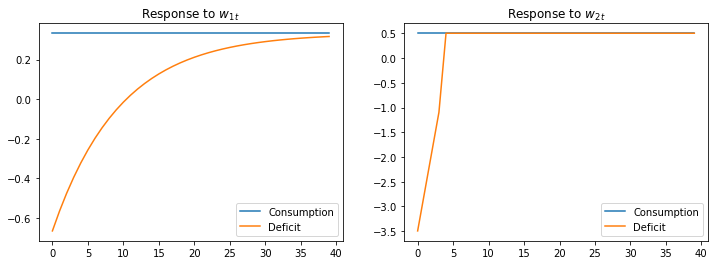

In [4]:
# This is Fig 8.E.1 from p.188 of HS2013

econ1.irf(ts_length=40, shock=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(econ1.c_irf, label='Consumption')
ax1.plot(econ1.c_irf - econ1.d_irf[:,0].reshape(40,1), label='Deficit')
ax1.legend()
ax1.set_title('Response to $w_{1t}$')

shock2 = np.array([[0], [1]])
econ1.irf(ts_length=40, shock=shock2)

ax2.plot(econ1.c_irf, label='Consumption')
ax2.plot(econ1.c_irf - econ1.d_irf[:,0].reshape(40, 1), label='Deficit')
ax2.legend()
ax2.set_title('Response to $w_{2t}$')
plt.show()

The above figure displays the impulse response of consumption and the
net-of-interest deficit to the innovations $w_t$ to the consumer's non-financial income 
or endowment process.

Consumption displays the characteristic "random walk" response with
respect to each innovation.

Each endowment innovation leads to a
temporary surplus followed by a permanent net-of-interest deficit.

The temporary surplus just offsets the permanent deficit in terms of
expected present value.

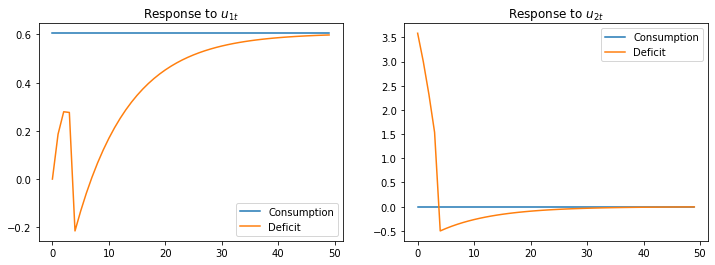

In [5]:
G_HS = np.vstack([econ1.Sc, econ1.Sc-econ1.Sd[0, :].reshape(1, 8)])
H_HS = 1e-8 * np.eye(2)  # Set very small so there is no measurement error
lss_hs = qe.LinearStateSpace(econ1.A0, econ1.C, G_HS, H_HS)

hs_kal = qe.Kalman(lss_hs)
w_lss = hs_kal.whitener_lss()
ma_coefs = hs_kal.stationary_coefficients(50, 'ma')

# This is Fig 8.E.2 from p.189 of HS2013

ma_coefs = ma_coefs
jj = 50
y1_w1 = np.empty(jj)
y2_w1 = np.empty(jj)
y1_w2 = np.empty(jj)
y2_w2 = np.empty(jj)

for t in range(jj):
    y1_w1[t] = ma_coefs[t][0, 0]
    y1_w2[t] = ma_coefs[t][0, 1]
    y2_w1[t] = ma_coefs[t][1, 0]
    y2_w2[t] = ma_coefs[t][1, 1]

# This scales the impulse responses to match those in the book
y1_w1 = sqrt(hs_kal.stationary_innovation_covar()[0, 0]) * y1_w1
y2_w1 = sqrt(hs_kal.stationary_innovation_covar()[0, 0]) * y2_w1
y1_w2 = sqrt(hs_kal.stationary_innovation_covar()[1, 1]) * y1_w2
y2_w2 = sqrt(hs_kal.stationary_innovation_covar()[1, 1]) * y2_w2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(y1_w1, label='Consumption')
ax1.plot(y2_w1, label='Deficit')
ax1.legend()
ax1.set_title('Response to $u_{1t}$')

ax2.plot(y1_w2, label='Consumption')
ax2.plot(y2_w2, label='Deficit')
ax2.legend()
ax2.set_title('Response to $u_{2t}$')
plt.show()

The above figure displays the impulse response of consumption and the
deficit to the innovations in the econometrician's Wold representation

- this is the object that would be recovered from a high order vector
  autoregression on the econometrician's observations.

Consumption responds only to the first innovation

- this is indicative of the Granger causality imposed on the
  $[c_t, c_t - d_t]$ process by Hall's model: consumption Granger
  causes $c_t - d_t$, with no reverse causality.

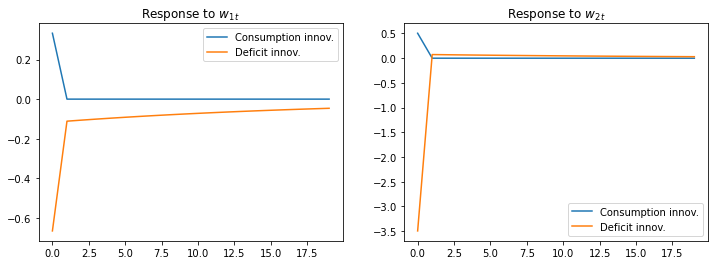

In [6]:
# This is Fig 8.E.3 from p.189 of HS2013

jj = 20
irf_wlss = w_lss.impulse_response(jj)
ycoefs = irf_wlss[1]
# Pull out the shocks
a1_w1 = np.empty(jj)
a1_w2 = np.empty(jj)
a2_w1 = np.empty(jj)
a2_w2 = np.empty(jj)

for t in range(jj):
    a1_w1[t] = ycoefs[t][0, 0]
    a1_w2[t] = ycoefs[t][0, 1]
    a2_w1[t] = ycoefs[t][1, 0]
    a2_w2[t] = ycoefs[t][1, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(a1_w1, label='Consumption innov.')
ax1.plot(a2_w1, label='Deficit innov.')
ax1.set_title('Response to $w_{1t}$')
ax1.legend()
ax2.plot(a1_w2, label='Consumption innov.')
ax2.plot(a2_w2, label='Deficit innov.')
ax2.legend()
ax2.set_title('Response to $w_{2t}$')
plt.show()

The above figure displays the impulse responses of $u_t$ to
$w_t$, as depicted in:

$$
u_t = \sum_{j=0}^\infty \alpha_j w_{t-j}
$$

While the responses of the innovations to consumption are concentrated
at lag zero for both components of $w_t$, the responses of the
innovations to $(c_t - d_t)$ are spread over time (especially in
response to $w_{1t}$).

Thus, the innovations to $(c_t - d_t)$ as revealed by the vector
autoregression depend on what the economic agent views as "old news".